In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv(r"C:\Projects\Uber_fare_prediction\uber.csv\uber.csv")



In [2]:
# Initial Data Cleaning
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')
data = data.dropna()  # Drop rows with missing values
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 100)]
data = data[(data['pickup_longitude'] >= -180) & (data['pickup_longitude'] <= 180)]
data = data[(data['dropoff_longitude'] >= -180) & (data['dropoff_longitude'] <= 180)]
data = data[(data['pickup_latitude'] >= -90) & (data['pickup_latitude'] <= 90)]
data = data[(data['dropoff_latitude'] >= -90) & (data['dropoff_latitude'] <= 90)]




In [3]:
# Feature Engineering
data['distance'] = data.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                                   (row['dropoff_latitude'], row['dropoff_longitude'])).km, axis=1)
data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['rush_hour'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)



In [4]:
# Additional Features
data['distance_category'] = pd.cut(data['distance'], bins=[0, 2, 5, 10, 20, np.inf],
                                   labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
data = pd.get_dummies(data, columns=['distance_category'], drop_first=True)

data['log_distance'] = np.log1p(data['distance'])
data['log_fare_amount'] = np.log1p(data['fare_amount'])




In [5]:
# Handle Outliers
fare_cap = data['fare_amount'].quantile(0.99)
distance_cap = data['distance'].quantile(0.99)
data = data[(data['fare_amount'] <= fare_cap) & (data['distance'] <= distance_cap)]

# Drop unnecessary columns
data = data.drop(['key', 'pickup_datetime'], axis=1)



In [6]:
# Split Data
X = data.drop(['fare_amount', 'log_fare_amount'], axis=1)
y = data['fare_amount']  # Or use 'log_fare_amount' for transformed target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [7]:
# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [8]:
# Evaluate Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 12.506732133578005
R-squared: 0.7870192899040762


Average CV MSE: 12.291188007804067


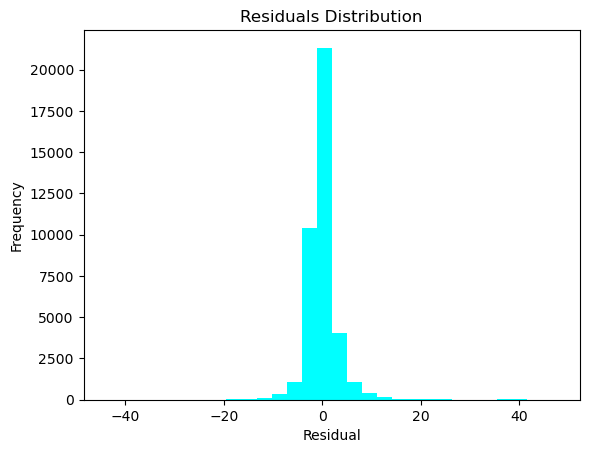

In [9]:
# Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Average CV MSE: {-cv_scores.mean()}")

# Residual Analysis
residuals = y_test - y_pred
plt.hist(residuals, bins=30, color='cyan')
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()



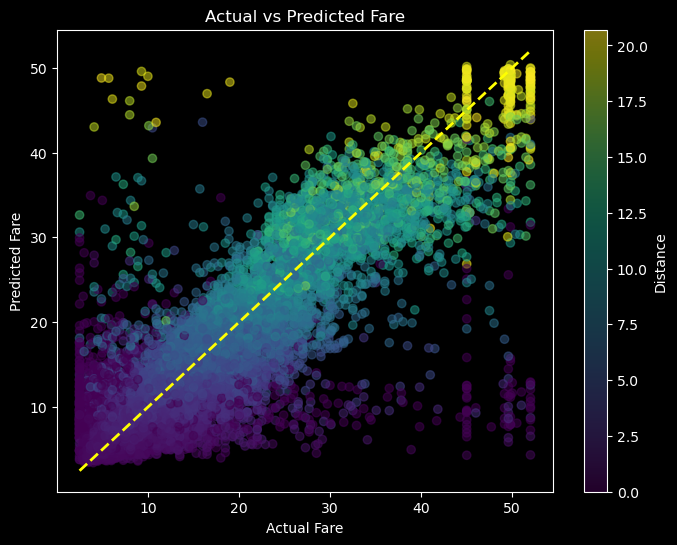

In [10]:
# Improved Visualization
plt.style.use('dark_background')
fig, ax = plt.subplots(facecolor='black', figsize=(8, 6))
scatter = ax.scatter(y_test, y_pred, c=X_test['distance'], cmap='viridis', alpha=0.5)
fig.colorbar(scatter, label='Distance')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='yellow', linestyle='--', linewidth=2)
ax.set_xlabel('Actual Fare', color='white')
ax.set_ylabel('Predicted Fare', color='white')
ax.set_title('Actual vs Predicted Fare', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Actual and predicted fares
y_test = [10, 15, 25, 12, 30]  # Example actual fares
y_pred = [9.5, 16, 24.5, 12.5, 29]  # Example predicted fares

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# R-Squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-Squared: {r2}")


Mean Absolute Error: 0.7
Mean Squared Error: 0.55
Root Mean Squared Error: 0.7416198487095663
R-Squared: 0.9908698539176627
